<a href="https://colab.research.google.com/github/amita-kapoor/FaceRecognition/blob/master/Source/HNN/Bn_face_VGG16_random_datasplit_seed_set_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Face recognition for home surveillance using transfer learning: Base model is VGG16 model trained on imagenet dataset. 
# training and validation data split randomly
# seed_set: random, numoy, os, keras initializer, tf
# calculated train, test, validation accuracy



In [2]:
#experiment = Experiment(project_name="Classification model")
#experiment.log_other("random seed", 10)

In [3]:
# https://drive.google.com/file/d/16Cpr_K8wflV1SiMs3yH3KPCpyG-NwFsB/view?usp=sharing
# random split
# https://drive.google.com/file/d/1fjBB65hrc7iJN4hv8_djFtWGtwOxAaKz/view?usp=sharing

# https://drive.google.com/file/d/1pg3fIhD_jPadsDIwJ4Lsjk5LCydqp1xb/view?usp=sharing

In [4]:
!gdown --id 1pg3fIhD_jPadsDIwJ4Lsjk5LCydqp1xb

Downloading...
From: https://drive.google.com/uc?id=1pg3fIhD_jPadsDIwJ4Lsjk5LCydqp1xb
To: /content/faceImages3.zip
8.80MB [00:00, 21.3MB/s]


In [5]:
!mkdir "faceImages"

In [6]:
type('faceImages3.zip')

str

In [7]:
!unzip "/content/faceImages3.zip" -d "/content/faceImages/"

Archive:  /content/faceImages3.zip
   creating: /content/faceImages/faceImages3/
   creating: /content/faceImages/faceImages3/data/
   creating: /content/faceImages/faceImages3/data/Chirag/
  inflating: /content/faceImages/faceImages3/data/Chirag/face_298.jpg  
  inflating: /content/faceImages/faceImages3/data/Chirag/face_299.jpg  
  inflating: /content/faceImages/faceImages3/data/Chirag/face_300.jpg  
  inflating: /content/faceImages/faceImages3/data/Chirag/face_301.jpg  
  inflating: /content/faceImages/faceImages3/data/Chirag/face_305.jpg  
  inflating: /content/faceImages/faceImages3/data/Chirag/face_306.jpg  
  inflating: /content/faceImages/faceImages3/data/Chirag/face_317.jpg  
  inflating: /content/faceImages/faceImages3/data/Chirag/face_462.jpg  
   creating: /content/faceImages/faceImages3/data/Gunjan/
  inflating: /content/faceImages/faceImages3/data/Gunjan/face_154.jpg  
  inflating: /content/faceImages/faceImages3/data/Gunjan/face_175.jpg  
  inflating: /content/faceImages

In [8]:
!ls

faceImages  faceImages3.zip  sample_data


In [9]:
# https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752
seed_value = 13438

In [10]:
#from tensorflow.keras.layers import Embedding
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

In [11]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
import cv2

from tensorflow.keras import layers
from tensorflow.keras import initializers # https://keras.io/api/layers/initializers/
layer = layers.Dense(
    units=64,
    kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()
)

import random
random.seed(seed_value) 

from numpy.random import seed
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)  # https://github.com/pytorch/pytorch/issues/11278

Using TensorFlow backend.


In [12]:
print('Without seed')
print(np.random.rand(4))
print(np.random.rand(4))

Without seed
[0.23485932 0.29080151 0.40393218 0.5212769 ]
[0.23079737 0.93661399 0.52566437 0.71422455]


In [13]:
print('With seed')
np.random.seed(seed_value)
print(np.random.rand(4))
np.random.seed(seed_value)
print(np.random.rand(4))

With seed
[0.23485932 0.29080151 0.40393218 0.5212769 ]
[0.23485932 0.29080151 0.40393218 0.5212769 ]


In [14]:
## We then define couple of parameters,
# dimensions of our images.  
img_width, img_height = 224, 224  
  
top_model_weights_path = 'bn_fc_faces_VGG16.hdf5' 
data_dir = 'faceImages/faceImages3/data'  
#validation_data_dir = 'faceImages/faceImages/valid'
test_data_dir = 'faceImages/faceImages3/test'
  
# number of epochs to train top model  
epochs = 300  
# batch size used by flow_from_directory and predict_generator  
batch_size = 64 

In [15]:
## We create the VGG16 model - without the final fully-connected layers (by specifying include_top=False) - and load the ImageNet weights,
model = applications.VGG16(include_top=False, weights='imagenet') 

58892288/58889256 [==============================] - 2s 0us/step


In [16]:
# https://keras.io/api/preprocessing/image/
# https://medium.com/datadriveninvestor/keras-imagedatagenerator-methods-an-easy-guide-550ecd3c0a92

# ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation.
# rescale: rescaling factor. 
#        : multiply the data by the value provided (after applying all other transformations).
#flow_from_directory Method : This method will identify classes automatically from the folder name.

In [17]:
# Save bottlenack features of training data
## We then create the data generator for training images, and run them on the VGG16 model to save the bottleneck features for training.
## generator.filenames contains all the filenames of the training set. By getting its length, we can get the size of the training set.
## generator.class_indices is the map/dictionary for the class-names and their indexes. Getting its length gives us the number of classes.
datagen = ImageDataGenerator(validation_split=0.3, rescale=1. / 255)  
   
generator = datagen.flow_from_directory(
    data_dir,  
    subset='training',
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False,
    seed = seed_value)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = model.predict_generator(  
     generator, predict_size_train)  
   
np.savez('bn_train_faces_VGG16.npz', bottleneck_features_train)

Found 198 images belonging to 17 classes.


In [18]:
# Save bottlenack features of validation data
generator = datagen.flow_from_directory(  
     data_dir,  
     subset='validation',
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False,
     seed = seed_value)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = model.predict_generator(  
     generator, predict_size_validation)  
   
np.savez('bn_validation_faces_VGG16.npz', bottleneck_features_validation) 

Found 75 images belonging to 17 classes.


In [19]:
# Save bottlenack features of test data
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False,
     seed = seed_value)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = model.predict_generator(  
     generator, predict_size_test)  
   
np.savez('bn_test_faces_VGG16.npz', bottleneck_features_test) 

Found 57 images belonging to 17 classes.


In [20]:
# convert the training labels to categorical vectors
#datagen_top = ImageDataGenerator(validation_split=0.3, rescale=1./255)  
generator_top = datagen.flow_from_directory(  
         data_dir,
         subset='training',  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False, 
         seed =seed_value)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
print(nb_train_samples)
print(num_classes)
print(generator_top.class_indices)
print(generator_top.filenames)   

# load the bottleneck features saved earlier  
train_data = np.load('bn_train_faces_VGG16.npz')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes 
print(train_labels)
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  
#print(train_labels[20])

Found 198 images belonging to 17 classes.
198
17
{'Chirag': 0, 'Gunjan': 1, 'Jyoti': 2, 'Kiran': 3, 'Meghna': 4, 'Mohit': 5, 'Neha': 6, 'Nilesh': 7, 'Nitin': 8, 'Priyanka': 9, 'Promila': 10, 'Punit': 11, 'Savita': 12, 'Simran': 13, 'Som': 14, 'Veenu': 15, 'Vinita': 16}
['Chirag/face_300.jpg', 'Chirag/face_301.jpg', 'Chirag/face_305.jpg', 'Chirag/face_306.jpg', 'Chirag/face_317.jpg', 'Chirag/face_462.jpg', 'Gunjan/face_465.jpg', 'Gunjan/face_469.jpg', 'Gunjan/face_473.jpg', 'Gunjan/face_480.jpg', 'Gunjan/face_486.jpg', 'Gunjan/face_504.jpg', 'Gunjan/face_507.jpg', 'Gunjan/face_509.jpg', 'Gunjan/face_510.jpg', 'Gunjan/face_512.jpg', 'Gunjan/face_519.jpg', 'Gunjan/face_76.jpg', 'Jyoti/face_474.jpg', 'Jyoti/face_475.jpg', 'Jyoti/face_477.jpg', 'Jyoti/face_479.jpg', 'Jyoti/face_485.jpg', 'Jyoti/face_487.jpg', 'Jyoti/face_84.jpg', 'Kiran/face_373.jpg', 'Kiran/face_375.jpg', 'Kiran/face_379.jpg', 'Kiran/face_380.jpg', 'Kiran/face_384.jpg', 'Kiran/face_385.jpg', 'Kiran/face_400.jpg', 'Kiran/fa

In [21]:
#convert the validation labels to categorical vectors
generator_top = datagen.flow_from_directory(  
        data_dir, 
        subset='validation', 
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False, 
         seed = seed_value)  
   
nb_validation_samples = len(generator_top.filenames)  
  
validation_data = np.load('bn_validation_faces_VGG16.npz')  
   
validation_labels = generator_top.classes  
print(validation_labels) 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)
#print(validation_labels) 
print(nb_validation_samples)

Found 75 images belonging to 17 classes.
[ 0  0  1  1  1  1  1  2  2  2  3  3  3  3  3  3  3  4  4  4  4  4  4  4
  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  8
  8  9  9 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 13 14 14 15
 15 16 16]
75


In [22]:
#convert the test labels to categorical vectors
generator_top = datagen.flow_from_directory(  
        test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False, 
         seed = seed_value)  
   
nb_test_samples = len(generator_top.filenames)  
  
test_data = np.load('bn_test_faces_VGG16.npz')  
   
test_labels = generator_top.classes
print(test_labels)   
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 57 images belonging to 17 classes.
[ 0  0  0  1  1  1  1  2  2  3  3  3  3  3  4  4  4  4  5  5  5  6  6  6
  6  6  7  7  7  7  7  8  8  8  9  9 10 10 10 11 11 11 11 11 12 12 12 12
 13 13 14 14 15 15 16 16 16]


In [23]:
# Description of npz files
train_data.files, validation_data.files, test_data.files, train_data['arr_0'].shape, validation_data['arr_0'].shape, test_data['arr_0'].shape

(['arr_0'],
 ['arr_0'],
 ['arr_0'],
 (198, 7, 7, 512),
 (75, 7, 7, 512),
 (57, 7, 7, 512))

In [24]:
# Description of labels of dataset
train_labels.shape, validation_labels.shape, test_labels.shape

((198, 17), (75, 17), (57, 17))

In [25]:
### Define your architecture.
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Dense
from keras.models import Sequential
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_data['arr_0'].shape[1:]))
#model.add(Dense(400, activation='relu')) 
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.5, seed=seed_value))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 17)                4369      
Total params: 136,721
Trainable params: 136,209
Non-trainable params: 512
_________________________________________________________________


In [26]:
### Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the model.
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath=top_model_weights_path, 
                               verbose=1, save_best_only=True)

history = model.fit(train_data['arr_0'], train_labels,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(validation_data['arr_0'], validation_labels),callbacks=[checkpointer], verbose=1, shuffle=True)  
   
#model.save_weights(top_model_weights_path)  
   
(eval_loss, eval_accuracy) = model.evaluate(  
     validation_data['arr_0'], validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))

Train on 198 samples, validate on 75 samples
Epoch 1/300
198/198 [==============================] - 0s 2ms/step - loss: 3.3641 - accuracy: 0.0808 - val_loss: 3.1072 - val_accuracy: 0.0267

Epoch 00001: val_loss improved from inf to 3.10722, saving model to bn_fc_faces_VGG16.hdf5
Epoch 2/300
198/198 [==============================] - 0s 181us/step - loss: 2.7412 - accuracy: 0.1364 - val_loss: 3.0231 - val_accuracy: 0.0267

Epoch 00002: val_loss improved from 3.10722 to 3.02312, saving model to bn_fc_faces_VGG16.hdf5
Epoch 3/300
198/198 [==============================] - 0s 173us/step - loss: 2.3401 - accuracy: 0.2879 - val_loss: 2.9442 - val_accuracy: 0.0267

Epoch 00003: val_loss improved from 3.02312 to 2.94418, saving model to bn_fc_faces_VGG16.hdf5
Epoch 4/300
198/198 [==============================] - 0s 193us/step - loss: 2.1141 - accuracy: 0.3434 - val_loss: 2.8821 - val_accuracy: 0.0533

Epoch 00004: val_loss improved from 2.94418 to 2.88213, saving model to bn_fc_faces_VGG16.hd

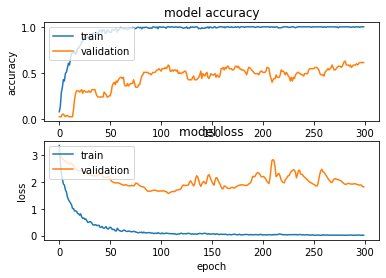

In [27]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()

In [28]:
# Calculate accuracy on test dataset
# Define architecture
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=test_data['arr_0'].shape[1:]))
#model.add(Dense(400, activation='relu')) 
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.5, seed=seed_value))
model.add(Dense(num_classes, activation='softmax'))

In [29]:
#Load saved weights
model.load_weights(top_model_weights_path)

In [30]:
### Calculate classification accuracy on the test dataset.
model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_data['arr_0']]

# report test accuracy
test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_labels, axis=1))/len(model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.6140%


In [31]:
len(test_data['arr_0']), len(test_labels)

(57, 57)

In [32]:
print(model_predictions), test_labels

[0, 9, 12, 1, 1, 1, 4, 2, 6, 6, 6, 6, 1, 12, 4, 6, 4, 4, 5, 6, 5, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 0, 8, 16, 1, 9, 12, 10, 6, 2, 11, 11, 9, 11, 12, 12, 6, 12, 13, 1, 2, 2, 6, 16, 6, 4, 4]


(None, array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 

In [33]:
# Calculate accuracy on train dataset
# Define architecture
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_data['arr_0'].shape[1:]))
#model.add(Dense(400, activation='relu')) 
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.5, seed=seed_value))
model.add(Dense(num_classes, activation='softmax'))

In [34]:
#Load saved weights
model.load_weights(top_model_weights_path)

In [35]:
### Calculate classification accuracy on the test dataset.
model_predictions_train = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in train_data['arr_0']]

In [36]:
# report test accuracy
train_accuracy = 100*np.sum(np.array(model_predictions_train)==np.argmax(train_labels, axis=1))/len(model_predictions_train)
print('Train accuracy: %.4f%%' % train_accuracy)

Train accuracy: 100.0000%


In [37]:
# Calculate accuracy on validation dataset
# Define architecture
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=validation_data['arr_0'].shape[1:]))
#model.add(Dense(400, activation='relu')) 
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.5, seed=seed_value))
model.add(Dense(num_classes, activation='softmax'))

In [38]:
#Load saved weights
model.load_weights(top_model_weights_path)

In [39]:
### Calculate classification accuracy on the validation dataset.
model_predictions_validation = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in validation_data['arr_0']]

In [40]:
# report validation accuracy
validation_accuracy = 100*np.sum(np.array(model_predictions_validation)==np.argmax(validation_labels, axis=1))/len(model_predictions_validation)
print('Validation accuracy: %.4f%%' % validation_accuracy)

Validation accuracy: 58.6667%


In [41]:
train_accuracy, validation_accuracy, test_accuracy

(100.0, 58.666666666666664, 45.6140350877193)

In [42]:
# image_path = 'data/eval/Malabar_Pied_Hornbill.png'  
image_path = '/content/faceImages/faceImages2/test/001.Ankit/Ankit_0008.jpg'
   
orig = cv2.imread(image_path)  
   
print("[INFO] loading and preprocessing image...")  
image = load_img(image_path, target_size=(224, 224))  
image = img_to_array(image)  
plt.imshow(image)   
# important! otherwise the predictions will be '0'  
image = image / 255 

plt.imshow(image)   
image = np.expand_dims(image, axis=0) 

[INFO] loading and preprocessing image...


FileNotFoundError: ignored

In [ ]:
# build the VGG16 network  
model = applications.VGG16(include_top=False, weights='imagenet')  
   
# get the bottleneck prediction from the pre-trained VGG16 model  
bottleneck_prediction = model.predict(image) 
print(bottleneck_prediction.shape)

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=bottleneck_prediction.shape[1:]))
#model.add(Dense(400, activation='relu')) 
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.5, seed=seed_value))
model.add(Dense(num_classes, activation='softmax'))

model.load_weights(top_model_weights_path)  
   
# use the bottleneck prediction on the top model to get the final classification  
class_predicted = model.predict_classes(bottleneck_prediction)  
print(class_predicted)

In [ ]:
inID = class_predicted[0]  
  
class_dictionary = generator_top.class_indices  
   
inv_map = {v: k for k, v in class_dictionary.items()}  
   
label = inv_map[inID]  
   
# get the prediction label  
print("Image ID: {}, Label: {}".format(inID, label)) 